# AI Economy Score Predictor - Full Pipeline

Complete end-to-end implementation of the earnings call sentiment → economic prediction → trading strategy pipeline.

## Setup & Configuration

In [38]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from data_acquisition import DataAcquisition
from llm_scorer import LLMScorer
from feature_engineering import FeatureEngineer
from prediction_model import PredictionModel
from signal_generator import SignalGenerator
from backtester import Backtester
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("✓ Pipeline modules loaded")
print(f"✓ Config loaded: {len(config)} sections")

✓ Pipeline modules loaded
✓ Config loaded: 9 sections


## Step 1: Data Acquisition

In [39]:
# Initialize data acquisition
data_acq = DataAcquisition('config.yaml')
sp500 = data_acq.fetch_sp500_constituents()
sp500.head(10)

✓ FRED API initialized
✓ Loaded 503 S&P 500 constituents


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
5,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
6,AMD,Advanced Micro Devices,Information Technology,Semiconductors,"Santa Clara, California",2017-03-20,2488,1969
7,AES,AES Corporation,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",1998-10-02,874761,1981
8,AFL,Aflac,Financials,Life & Health Insurance,"Columbus, Georgia",1999-05-28,4977,1955
9,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,1090872,1999


# Data Fetch Testing

In [ ]:
import pandas as pd
from data_acquisition import DataAcquisition

print("=" * 60)
print("FREE LLM OPTIONS AVAILABLE!")
print("=" * 60)
print("✅ Hugging Face: No setup, runs in Python (free)")
print("✅ Ollama: Install once, better quality (free)")
print("See FREE_LLM_SETUP.md for details")
print("=" * 60)

data = DataAcquisition("config.yaml")
transcripts = data.fetch_earnings_transcripts('2015-01-01', '2026-01-01')

# Filter to ensure only 2025 data
transcripts['date'] = pd.to_datetime(transcripts['date'])
print(f"Loaded {len(transcripts)} transcripts for 2025")
print(f"Date range: {transcripts['date'].min().date()} to {transcripts['date'].max().date()}")

macro = data.fetch_macro_data('2025-01-01', '2025-12-31')
print(f"Loaded {len(macro)} macro indicators")
sp500 = data.fetch_sp500_constituents()
print(f"Loaded {len(sp500)} S&P 500 stocks")

✓ FRED API initialized
Fetching transcripts from Hugging Face (kurry/sp500_earnings_transcripts)...
Converting to DataFrame...
✓ Loaded 33,362 total transcripts
✓ Loaded 503 S&P 500 constituents
Filtering by date and S&P 500 membership...
  After date filter: 21,135 transcripts
✓ Final result: 18,103 S&P 500 transcripts (2015-01-01 to 2026-01-01)
Loaded 18103 transcripts for 2025
Date range: 2015-01-06 to 2025-05-15
✓ Fetched gdp: 3 observations
✓ Fetched industrial_production: 12 observations
✓ Fetched employment: 12 observations
✓ Fetched wages: 12 observations
Loaded 4 macro indicators
✓ Loaded 503 S&P 500 constituents
Loaded 503 S&P 500 stocks


## Step 2: Fetch Macro Data (FRED API)

**Note**: If you get FRED API errors, restart the kernel to reload the config with the updated API key.

In [4]:
# Fetch macroeconomic data for 2025 only
start_date = '2025-01-01'
end_date = '2025-12-31'
macro_data = data_acq.fetch_macro_data(start_date, end_date)
print(f"\nMacroeconomic Data (2025):")
for name, df in macro_data.items():
    if len(df) > 0:
        df_temp = df.copy()
        df_temp['date'] = pd.to_datetime(df_temp['date'])
        # Filter to 2025
        df_2025 = df_temp[df_temp['date'] >= '2025-01-01']
        print(f"  {name}: {len(df_2025)} observations (filtered to 2025)")

✓ Fetched gdp: 3 observations
✓ Fetched industrial_production: 12 observations
✓ Fetched employment: 12 observations
✓ Fetched wages: 12 observations

Macroeconomic Data (2025):
  gdp: 3 observations (filtered to 2025)
  industrial_production: 12 observations (filtered to 2025)
  employment: 12 observations (filtered to 2025)
  wages: 12 observations (filtered to 2025)


In [5]:
import pandas as pd
import re

pmi_path = 'pmi_data.csv'
pmi_df = pd.read_csv(pmi_path)
pmi_df.columns = [c.strip().lower().replace(' ', '_') for c in pmi_df.columns]
print("Columns in PMI file:", pmi_df.columns.tolist())

# Find date and PMI columns
date_col = [col for col in pmi_df.columns if 'date' in col][0]
pmi_col = [col for col in pmi_df.columns if 'pmi' in col][0]

def clean_date(val):
    # Extract the part before the first parenthesis
    val = str(val).split('(')[0].strip()
    try:
        return pd.to_datetime(val)
    except Exception:
        return pd.NaT

pmi_df[date_col] = pmi_df[date_col].apply(clean_date)
pmi_df = pmi_df.dropna(subset=[date_col, pmi_col])

# Rename columns to standard names
pmi_df = pmi_df.rename(columns={date_col: 'date', pmi_col: 'pmi'})

print(f"Loaded PMI data: {len(pmi_df)} rows")
print(pmi_df.tail())

Columns in PMI file: ['date', 'pmi']
Loaded PMI data: 133 rows
          date   pmi
128 2015-05-01  51.5
129 2015-04-01  51.5
130 2015-03-02  52.9
131 2015-02-02  53.5
132 2015-01-02  55.5


In [6]:
# Filter PMI from 2025 onwards and create daily index for merging
pmi_df = pmi_df[pmi_df['date'] >= '2024-12-01'].copy()
pmi_df = pmi_df.sort_values('date')

# Create a complete daily date range for 2025
date_range = pd.date_range(start='2024-12-01', end='2025-12-31', freq='D')
pmi_daily = pd.DataFrame({'date': date_range})

# Merge and forward-fill PMI values
pmi_daily = pmi_daily.merge(pmi_df, on='date', how='left')
# Use both forward-fill and backward-fill to handle initial NaN values
pmi_daily['pmi'] = pmi_daily['pmi'].ffill().bfill()

print(f"Filtered PMI data: {len(pmi_df)} original rows")
print(f"Created daily PMI data: {len(pmi_daily)} rows (forward-filled)")
print(f"\nFirst few rows:")
print(pmi_daily.head(10))
print(f"\nCheck for remaining NaN values: {pmi_daily['pmi'].isna().sum()}")

# Use the daily PMI data for merging
pmi_df = pmi_daily

Filtered PMI data: 14 original rows
Created daily PMI data: 396 rows (forward-filled)

First few rows:
        date   pmi
0 2024-12-01  48.4
1 2024-12-02  48.4
2 2024-12-03  48.4
3 2024-12-04  48.4
4 2024-12-05  48.4
5 2024-12-06  48.4
6 2024-12-07  48.4
7 2024-12-08  48.4
8 2024-12-09  48.4
9 2024-12-10  48.4

Check for remaining NaN values: 0


In [7]:
# Verify PMI values change throughout the year (show monthly transitions)
print("PMI values at monthly transitions:")
sample_dates = ['2025-01-03', '2025-02-03', '2025-03-03', '2025-04-01', 
                '2025-05-01', '2025-06-02', '2025-07-01', '2025-08-01']
for date in sample_dates:
    value = pmi_df[pmi_df['date'] == date]['pmi'].values
    if len(value) > 0:
        print(f"  {date}: {value[0]}")

print(f"\nUnique PMI values in 2025: {sorted(pmi_df['pmi'].unique())}")
print(f"This is correct - PMI is monthly, so each value repeats until the next release")

PMI values at monthly transitions:
  2025-01-03: 49.3
  2025-02-03: 50.9
  2025-03-03: 50.3
  2025-04-01: 49.0
  2025-05-01: 48.7
  2025-06-02: 48.5
  2025-07-01: 49.0
  2025-08-01: 48.0

Unique PMI values in 2025: [np.float64(48.0), np.float64(48.2), np.float64(48.4), np.float64(48.5), np.float64(48.7), np.float64(49.0), np.float64(49.1), np.float64(49.3), np.float64(50.3), np.float64(50.9)]
This is correct - PMI is monthly, so each value repeats until the next release


In [8]:
# Fetch control variables
controls = data_acq.fetch_control_variables(start_date, end_date)
print(f"\nControl Variables: {len(controls)} observations")
controls.head()

✓ Fetched yield curve slope
✓ Fetched consumer sentiment
✓ Fetched unemployment rate
✗ No local PMI data provided; PMI not included in controls.
✓ Control variables: 12 observations

Control Variables: 12 observations


,yield_curve_slope,consumer_sentiment,unemployment_rate
2025-01-01,0.36,71.7,4.0
2025-02-01,0.24,64.7,4.2
2025-03-01,0.31,57.0,4.2
2025-04-01,0.50,52.2,4.2
2025-05-01,0.50,52.2,4.3


In [9]:
data_acq.pmi_df = pmi_df
controls = data_acq.fetch_control_variables(start_date, end_date, pmi_df=pmi_df)

✓ Fetched yield curve slope
✓ Fetched consumer sentiment
✓ Fetched unemployment rate
✓ Used local PMI data: 365 rows
✓ Control variables: 365 observations


In [10]:
#rename index column to date
controls = controls.reset_index().rename(columns={'index': 'date'})

In [11]:
# make the index column date
controls = controls.groupby(controls['date'].dt.to_period('M')).last().reset_index(drop=True)
controls['date'] = pd.to_datetime(controls['date'].astype(str))
print(f"Resampled to monthly: {len(controls)} observations")
controls.head(100)

Resampled to monthly: 12 observations


,date,yield_curve_slope,consumer_sentiment,unemployment_rate,pmi
0,2025-01-31,0.36,71.7,4.0,49.3
1,2025-02-28,0.24,64.7,4.2,50.9
2,2025-03-31,0.31,57.0,4.2,50.3
3,2025-04-30,0.50,52.2,4.2,49.0
4,2025-05-31,0.50,52.2,4.3,48.7
5,2025-06-30,0.49,60.7,4.1,48.5
6,2025-07-31,0.51,61.7,4.3,49.0
7,2025-08-31,0.56,58.2,4.3,48.0
8,2025-09-30,0.55,55.1,4.4,48.7
9,2025-10-31,0.54,53.6,4.4,49.1


## Step 2: LLM Scoring

In [ ]:
from llm_scorer import LLMScorer

# Initialize LLM scorer with FREE models!
# Check config.yaml - should be set to 'huggingface' or 'ollama'
scorer = LLMScorer('config.yaml')

print(f"\n{'='*70}")
print(f"LLM Provider: {scorer.provider}")
print(f"Model: {scorer.llm_config['model']}")
print(f"{'='*70}")

# Test the scorer with sample text
test_text = """
The US economy is showing strong growth momentum. 
We're seeing robust consumer spending and business investment.
Our outlook for the next quarter is very positive.
"""

print("\n🧪 Testing LLM scorer...")
test_score = scorer.score_text(test_text)
print(f"✅ Test score: {test_score}/5 (Expected: 4 or 5 for positive text)")

if test_score is None:
    print("\n⚠️ Scoring failed! Check:")
    print("   - For Ollama: Is 'ollama serve' running? Did you pull the model?")
    print("   - For Hugging Face: Is the model downloaded? Check internet connection.")
    print(f"\n📖 See FREE_LLM_SETUP.md for help!")
else:
    print(f"\n✅ LLM scorer is working! Ready to score transcripts.")

## Step 3: Feature Engineering

In [13]:
def aggregate_scores_by_quarter(scored_transcripts):
    """
    Aggregate individual transcript scores into quarterly AGG scores.
    
    Args:
        scored_transcripts: List of dicts with 'symbol', 'date', 'score', 'market_cap'
        
    Returns:
        DataFrame with quarterly AGG scores
    """
    df = pd.DataFrame(scored_transcripts)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['quarter_date'] = df['date'].dt.to_period('Q').dt.to_timestamp()
    
    # Aggregate by quarter using value-weighted average
    quarterly = df.groupby('quarter_date').apply(
        lambda x: np.average(x['score'], weights=x.get('market_cap', [1]*len(x)))
    ).reset_index()
    
    quarterly.columns = ['date', 'agg_score']
    quarterly['year'] = quarterly['date'].dt.year
    quarterly['quarter'] = quarterly['date'].dt.quarter
    
    return quarterly[['date', 'year', 'quarter', 'agg_score']]

# Example usage (commented out - requires real transcript scores):
# scored_transcripts = scorer.score_multiple_transcripts(transcripts)
# agg_scores = aggregate_scores_by_quarter(scored_transcripts)
# agg_scores.to_csv('agg_scores.csv', index=False)
print("✓ AGG score aggregation function defined")

✓ AGG score aggregation function defined


In [14]:
# Prepare transcripts for scoring (uses whatever was fetched based on config.yaml)
if 'transcripts' not in dir() or len(transcripts) == 0:
    print("ERROR: No transcripts loaded!")
    print("Please run the data acquisition cell first to load transcripts.")
    raise ValueError("Transcripts not loaded. Run data acquisition cell first.")

# Use the loaded transcripts
scoring_transcripts = transcripts.copy()
scoring_transcripts['date'] = pd.to_datetime(scoring_transcripts['date'])

# Generate save path based on date range
date_min = scoring_transcripts['date'].min()
date_max = scoring_transcripts['date'].max()
year_range = f"{date_min.year}_{date_max.year}"
save_path = f'scored_transcripts_{year_range}.csv'

print(f"Preparing to score {len(scoring_transcripts)} transcripts")
print(f"Date range: {date_min.date()} to {date_max.date()}")
print(f"Estimated cost: ${len(scoring_transcripts) * 0.001:.2f} - ${len(scoring_transcripts) * 0.002:.2f}")
print(f"Estimated time: {len(scoring_transcripts) * 2 / 60:.1f} - {len(scoring_transcripts) * 3 / 60:.1f} minutes")
print(f"Results will be saved to: {save_path}")

# Show breakdown by year
year_counts = scoring_transcripts['date'].dt.year.value_counts().sort_index()
print(f"\nTranscripts by year:")
for year, count in year_counts.items():
    print(f"  {year}: {count} transcripts")

print(f"\nCheckpoints will be saved every 50 transcripts")

Preparing to score 919 transcripts
Date range: 2025-01-10 to 2025-05-15
Estimated cost: $0.92 - $1.84
Estimated time: 30.6 - 46.0 minutes
Results will be saved to: scored_transcripts_2025_2025.csv

Transcripts by year:
  2025: 919 transcripts

Checkpoints will be saved every 50 transcripts


In [15]:
# Define the scoring function with progress tracking
import time
from tqdm.notebook import tqdm
from datetime import datetime

def score_quarter_transcripts(transcripts_df, scorer, save_path='scored_transcripts.csv'):
    """
    Score all transcripts with progress tracking, checkpointing, and error handling.
    """
    # First, inspect the data structure
    print("Inspecting data structure...")
    print(f"Type: {type(transcripts_df)}")
    print(f"Columns: {transcripts_df.columns.tolist()}")
    print(f"\nFirst row type: {type(transcripts_df.iloc[0])}")
    print(f"First row preview:")
    print(transcripts_df.iloc[0])
    
    print(f"\nScoring {len(transcripts_df)} transcripts...")
    print(f"Estimated cost: ${len(transcripts_df) * 0.001:.2f} (GPT-4o-mini)")
    print(f"Estimated time: {len(transcripts_df) * 2 / 60:.1f} minutes")
    
    # Check for existing progress
    try:
        existing = pd.read_csv(save_path)
        already_scored = set(existing['symbol'] + '_' + existing['date'].astype(str))
        print(f"Found {len(already_scored)} previously scored transcripts")
    except FileNotFoundError:
        already_scored = set()
        existing = pd.DataFrame()
    
    scored_results = []
    errors = []
    
    # Determine transcript column name - check what's actually in the DataFrame
    available_cols = transcripts_df.columns.tolist()
    transcript_col = None
    
    for possible_name in ['transcript', 'text', 'content', 'full_text', 'body']:
        if possible_name in available_cols:
            transcript_col = possible_name
            break
    
    if transcript_col is None:
        print(f"ERROR: Could not find transcript column. Available columns: {available_cols}")
        return existing if len(existing) > 0 else pd.DataFrame()
    
    print(f"Using transcript column: '{transcript_col}'")
    
    # Convert to dict records for easier iteration
    records = transcripts_df.to_dict('records')
    
    for idx, row in enumerate(tqdm(records, desc="Scoring")):
        # Handle different possible column names
        symbol = row.get('symbol') or row.get('ticker') or 'UNKNOWN'
        date = row.get('date') or row.get('filing_date') or 'UNKNOWN'
        transcript_id = f"{symbol}_{date}"
        
        # Skip if already scored
        if transcript_id in already_scored:
            continue
        
        try:
            # Get the transcript text
            transcript_text = row.get(transcript_col, '')
            
            if not transcript_text or transcript_text == '':
                errors.append({'symbol': symbol, 'date': date, 'error': 'Empty transcript'})
                continue
            
            # Score transcript - wrap in expected dictionary format
            # The scorer expects a dict with 'full_text' key
            transcript_dict = {'full_text': transcript_text}
            result = scorer.score_transcript(transcript_dict, use_md_a_only=False)
            score = result['firm_score']
            
            if score is None:
                errors.append({'symbol': symbol, 'date': date, 'error': 'Scoring returned None'})
                continue
            
            scored_results.append({
                'symbol': symbol,
                'date': date,
                'score': score,
                'transcript_length': len(str(transcript_text))
            })
            
            # Save checkpoint every 50 transcripts
            if len(scored_results) % 50 == 0:
                temp_df = pd.DataFrame(scored_results)
                combined = pd.concat([existing, temp_df], ignore_index=True)
                combined.to_csv(save_path, index=False)
                print(f"\nCheckpoint: Saved {len(combined)} scores")
            
            # Rate limiting (to avoid API limits)
            time.sleep(0.5)
            
        except Exception as e:
            errors.append({'symbol': symbol, 'date': date, 'error': str(e)})
            if idx < 5:  # Only print first few errors in detail
                print(f"\nError scoring {symbol}: {e}")
    
    # Final save - handle case where nothing was scored
    if scored_results:
        final_df = pd.DataFrame(scored_results)
        combined = pd.concat([existing, final_df], ignore_index=True)
        combined.to_csv(save_path, index=False)
        print(f"\nSaved {len(combined)} total scored transcripts to {save_path}")
    elif len(existing) > 0:
        combined = existing
        print(f"\nNo new transcripts scored. Returning {len(existing)} existing scores.")
    else:
        combined = pd.DataFrame(columns=['symbol', 'date', 'score', 'transcript_length'])
        print("\nWARNING: No transcripts were scored successfully!")
    
    if errors:
        error_df = pd.DataFrame(errors)
        error_df.to_csv('scoring_errors.csv', index=False)
        print(f"\nWARNING: {len(errors)} errors occurred (saved to scoring_errors.csv)")
        print(f"First few unique errors:")
        unique_errors = error_df['error'].value_counts().head(3)
        for error_msg, count in unique_errors.items():
            print(f"  {error_msg}: {count} occurrences")
    
    return combined

print("Scoring function ready")

Scoring function ready


In [16]:


#Check current chunk size
print(f"Current chunk size: {scorer.llm_config.get('chunk_size', 'not set')} characters")
print(f"Estimated chunks per transcript: {100000 // scorer.llm_config.get('chunk_size', 2000)} (for 100k char transcript)")

# Increase chunk size for faster scoring (reduces API calls by 4-6x)
scorer.llm_config['chunk_size'] = 10000  # Increase from 2000 to 10000

print(f"\n✓ Updated chunk size to: {scorer.llm_config['chunk_size']} characters")
print(f"✓ New estimated chunks: {100000 // scorer.llm_config['chunk_size']} per transcript")

Current chunk size: 2000 characters
Estimated chunks per transcript: 50 (for 100k char transcript)

✓ Updated chunk size to: 10000 characters
✓ New estimated chunks: 10 per transcript


In [17]:
# Run scoring (make sure you've run the previous cells first)
if 'scoring_transcripts' not in dir() or 'save_path' not in dir():
    print("ERROR: Please run the previous cell to prepare transcripts first.")
    raise NameError("Run the transcript preparation cell first")

print(f"Starting scoring at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

scored_data = score_quarter_transcripts(
    scoring_transcripts, 
    scorer, 
    save_path=save_path
)

print("=" * 70)
print(f"Completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Starting scoring at 2026-02-03 22:02:58
Inspecting data structure...
Type: <class 'pandas.core.frame.DataFrame'>
Columns: ['symbol', 'quarter', 'year', 'date', 'content', 'structured_content', 'company_name', 'company_id']

First row type: <class 'pandas.core.series.Series'>
First row preview:
symbol                                                                A
quarter                                                               1
year                                                               2025
date                                                2025-02-26 16:30:00
content               Operator: Good afternoon. My name is Regina, a...
structured_content    [{'speaker': 'Operator', 'text': 'Good afterno...
company_name                                 Agilent Technologies, Inc.
company_id                                                     154924.0
Name: 20, dtype: object

Scoring 919 transcripts...
Estimated cost: $0.92 (GPT-4o-mini)
Estimated time: 30.6 minutes
Found 919 pr

Scoring:   0%|          | 0/919 [00:00<?, ?it/s]


No new transcripts scored. Returning 919 existing scores.
Completed at 2026-02-03 22:02:58


In [18]:
# Display scoring results
if 'scored_data' in dir() and len(scored_data) > 0:
    print(f"\nFinal Results:")
    print(f"  Total scored: {len(scored_data)}")
    print(f"  Date range: {scored_data['date'].min()} to {scored_data['date'].max()}")
    print(f"  Average score: {scored_data['score'].mean():.2f}")
    print(f"  Score distribution:")
    print(scored_data['score'].value_counts().sort_index())
    print(f"\nSaved to: {save_path}")
else:
    print("No scored data available. Run the scoring cell first.")


Final Results:
  Total scored: 919
  Date range: 2025-01-10 08:30:00 to 2025-05-15 16:30:00
  Average score: 3.33
  Score distribution:
score
2.000000    7
2.131148    1
2.145433    4
2.163934    1
2.176863    1
           ..
4.540984    1
4.553770    2
4.656275    1
4.777442    1
4.783953    1
Name: count, Length: 424, dtype: int64

Saved to: scored_transcripts_2025_2025.csv


In [19]:
# Aggregate scored transcripts into quarterly AGG scores
if 'scored_data' not in dir() or len(scored_data) == 0:
    print("ERROR: No scored data available. Run the scoring cell first.")
else:
    print("Aggregating individual scores into quarterly AGG scores...")
    
    # Convert to DataFrame if needed
    if isinstance(scored_data, pd.DataFrame):
        scored_df = scored_data.copy()
    else:
        scored_df = pd.DataFrame(scored_data)
    
    # Ensure date column is datetime
    scored_df['date'] = pd.to_datetime(scored_df['date'])
    scored_df['year'] = scored_df['date'].dt.year
    scored_df['quarter'] = scored_df['date'].dt.quarter
    
    # Group by quarter and calculate aggregate score
    agg_scores = scored_df.groupby(['year', 'quarter']).agg({
        'score': ['mean', 'std', 'count']
    }).reset_index()
    
    agg_scores.columns = ['year', 'quarter', 'agg_score', 'score_std', 'num_firms']
    
    # Create quarter date
    agg_scores['date'] = pd.to_datetime(
        agg_scores['year'].astype(str) + '-Q' + agg_scores['quarter'].astype(str)
    )
    
    # Reorder columns
    final_agg_scores = agg_scores[['date', 'year', 'quarter', 'agg_score', 'score_std', 'num_firms']]
    
    # Save AGG scores (filename based on date range)
    agg_filename = f'agg_scores_{year_range}.csv'
    final_agg_scores.to_csv(agg_filename, index=False)
    print(f"\nSUCCESS: Saved {len(final_agg_scores)} quarterly AGG scores to {agg_filename}")
    
    # Display results
    print(f"\nAGG Scores Summary:")
    print(final_agg_scores)
    print(f"\nStatistics:")
    print(f"  Quarters covered: {len(final_agg_scores)}")
    print(f"  Date range: {final_agg_scores['date'].min().strftime('%Y-%m-%d')} to {final_agg_scores['date'].max().strftime('%Y-%m-%d')}")
    print(f"  Mean AGG score: {final_agg_scores['agg_score'].mean():.3f}")
    print(f"  Std AGG score: {final_agg_scores['agg_score'].std():.3f}")
    print(f"  Average firms/quarter: {final_agg_scores['num_firms'].mean():.0f}")

Aggregating individual scores into quarterly AGG scores...

SUCCESS: Saved 2 quarterly AGG scores to agg_scores_2025_2025.csv

AGG Scores Summary:
        date  year  quarter  agg_score  score_std  num_firms
0 2025-01-01  2025        1   3.439682   0.493708        488
1 2025-04-01  2025        2   3.209435   0.510541        431

Statistics:
  Quarters covered: 2
  Date range: 2025-01-01 to 2025-04-01
  Mean AGG score: 3.325
  Std AGG score: 0.163
  Average firms/quarter: 460


In [25]:
# Initialize feature engineer
engineer = FeatureEngineer('config.yaml')
print("✓ Feature engineer initialized")

✓ Feature engineer initialized


In [26]:
# Normalize scores (only if we have real data)
if len(agg_scores) > 0 and 'agg_score' in agg_scores.columns:
    normalized = engineer.normalize_scores(agg_scores, method='zscore', window=20)
    print("\nNormalized Scores:")
    print(normalized[['date', 'agg_score', 'agg_score_norm']].head(10))
else:
    normalized = pd.DataFrame()
    print("⚠ Cannot normalize without real AGG scores")

  Using expanding window (only 2 samples, window=20)

Normalized Scores:
        date  agg_score  agg_score_norm
0 2025-01-01   3.439682             NaN
1 2025-04-01   3.209435       -0.707107


In [27]:
# Create delta features (only if we have normalized data)
if len(normalized) > 0:
    with_deltas = engineer.create_delta_features(normalized)
    print("\nDelta Features:")
    print(with_deltas[['date', 'agg_score', 'yoy_change', 'qoq_change', 'momentum']].tail(10))
else:
    with_deltas = pd.DataFrame()
    print("⚠ Cannot create delta features without normalized scores")


Delta Features:
        date  agg_score  yoy_change  qoq_change  momentum
0 2025-01-01   3.439682         NaN         NaN       NaN
1 2025-04-01   3.209435         NaN   -0.230247       NaN


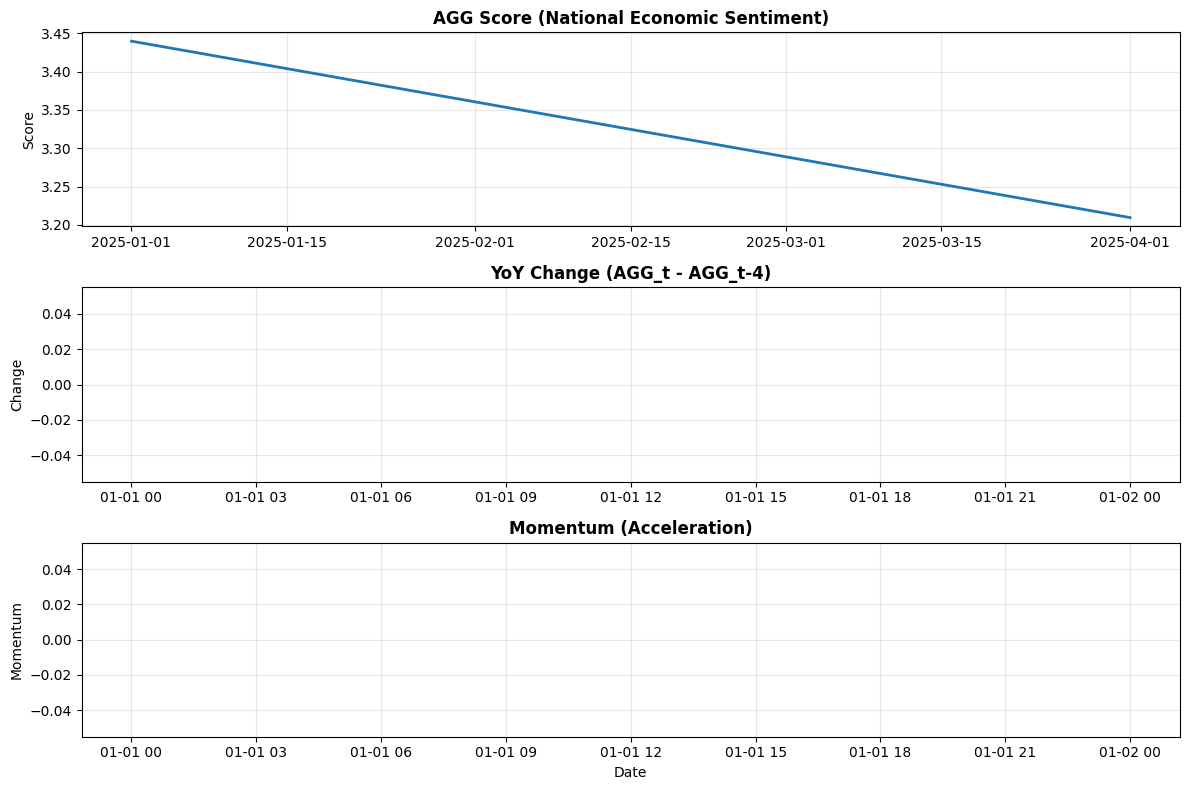

✓ Feature visualization complete


In [28]:
# Visualize AGG score and deltas (only if we have features)
if len(with_deltas) > 0:
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))

    # AGG score
    axes[0].plot(with_deltas['date'], with_deltas['agg_score'], linewidth=2)
    axes[0].set_title('AGG Score (National Economic Sentiment)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Score')
    axes[0].grid(True, alpha=0.3)

    # YoY change
    valid_yoy = with_deltas.dropna(subset=['yoy_change'])
    axes[1].bar(valid_yoy['date'], valid_yoy['yoy_change'], color='steelblue', alpha=0.7)
    axes[1].set_title('YoY Change (AGG_t - AGG_t-4)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Change')
    axes[1].grid(True, alpha=0.3)

    # Momentum
    valid_momentum = with_deltas.dropna(subset=['momentum'])
    axes[2].bar(valid_momentum['date'], valid_momentum['momentum'], color='coral', alpha=0.7)
    axes[2].set_title('Momentum (Acceleration)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Momentum')
    axes[2].set_xlabel('Date')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✓ Feature visualization complete")
else:
    print("⚠ Cannot visualize features without delta features")

## Step 4: Prediction Models

In [29]:
pred_model = PredictionModel('config.yaml')
print(dir(pred_model))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'config', 'diebold_mariano_test', 'evaluate_model', 'models_config', 'predict', 'prepare_regression_data', 'train_gdp_models', 'train_model', 'trained_models']


In [30]:
# Prepare training data - check date alignment first
X_train_df = with_deltas[['date', 'agg_score_norm', 'yoy_change', 'qoq_change', 'momentum']].dropna()

gdp_df = macro_data['gdp'].copy()
gdp_df['date'] = pd.to_datetime(gdp_df['date'])

print("Date ranges:")
print(f"  Features (AGG scores): {X_train_df['date'].min()} to {X_train_df['date'].max()}")
print(f"  GDP data: {gdp_df['date'].min()} to {gdp_df['date'].max()}")
print(f"\nFeature dates: {sorted(X_train_df['date'].unique())}")
print(f"\nGDP dates: {sorted(gdp_df['date'].unique())}")

# Merge features with GDP target
train_data = X_train_df.merge(gdp_df, on='date', how='inner')

print(f"\n After merge: {len(train_data)} matching rows")

if len(train_data) == 0:
    print("\nERROR: No matching dates between features and GDP data!")
    print("   This is expected - you have 2025 transcript scores but GDP data is historical.")
    print("\n   SOLUTION: For demo purposes, you can:")
    print("   1. Use features as-is (they're already engineered)")
    print("   2. Skip model training (no historical GDP to train on)")
    print("   3. Use these features for inference if you had a pre-trained model")
    print("\n   For a real system, you'd train on historical data (2005-2024) then predict 2025.")

# Separate features and target
X_train = train_data[['agg_score_norm', 'yoy_change', 'qoq_change', 'momentum']]
y_train = train_data['value']

print(f"\n✓ Training data: {X_train.shape}")
print(f"✓ Target data: {y_train.shape}")
print(f"✓ Features: {X_train.columns.tolist()}")
print(f"✓ Date range: {train_data['date'].min()} to {train_data['date'].max()}")

Date ranges:
  Features (AGG scores): NaT to NaT
  GDP data: 2025-01-01 00:00:00 to 2025-07-01 00:00:00

Feature dates: []

GDP dates: [Timestamp('2025-01-01 00:00:00'), Timestamp('2025-04-01 00:00:00'), Timestamp('2025-07-01 00:00:00')]

 After merge: 0 matching rows

ERROR: No matching dates between features and GDP data!
   This is expected - you have 2025 transcript scores but GDP data is historical.

   SOLUTION: For demo purposes, you can:
   1. Use features as-is (they're already engineered)
   2. Skip model training (no historical GDP to train on)
   3. Use these features for inference if you had a pre-trained model

   For a real system, you'd train on historical data (2005-2024) then predict 2025.

✓ Training data: (0, 4)
✓ Target data: (0,)
✓ Features: ['agg_score_norm', 'yoy_change', 'qoq_change', 'momentum']
✓ Date range: NaT to NaT


In [31]:
# DEBUG: Check what's in with_deltas
print("Debugging with_deltas DataFrame:")
print(f"Shape: {with_deltas.shape}")
print(f"Columns: {with_deltas.columns.tolist()}")
print(f"\nFirst few rows:")
print(with_deltas.head())
print(f"\nDate column info:")
if 'date' in with_deltas.columns:
    print(f"  Type: {with_deltas['date'].dtype}")
    print(f"  Non-null count: {with_deltas['date'].notna().sum()} / {len(with_deltas)}")
    print(f"  Unique dates: {with_deltas['date'].nunique()}")
    print(f"  Sample values: {with_deltas['date'].head().tolist()}")
else:
    print("  'date' column not found!")
    print(f"  Available columns: {with_deltas.columns.tolist()}")

Debugging with_deltas DataFrame:
Shape: (2, 10)
Columns: ['year', 'quarter', 'agg_score', 'score_std', 'num_firms', 'date', 'agg_score_norm', 'yoy_change', 'qoq_change', 'momentum']

First few rows:
   year  quarter  agg_score  score_std  num_firms       date  agg_score_norm  \
0  2025        1   3.439682   0.493708        488 2025-01-01             NaN   
1  2025        2   3.209435   0.510541        431 2025-04-01       -0.707107   

   yoy_change  qoq_change  momentum  
0         NaN         NaN       NaN  
1         NaN   -0.230247       NaN  

Date column info:
  Type: datetime64[ns]
  Non-null count: 2 / 2
  Unique dates: 2
  Sample values: [Timestamp('2025-01-01 00:00:00'), Timestamp('2025-04-01 00:00:00')]


In [ ]:
# Check for existing AGG score files with more historical data
import os
import glob

# Look for any agg_scores CSV files
agg_files = glob.glob('agg_scores_*.csv')
print(f"Found {len(agg_files)} AGG score files:")
for file in agg_files:
    df_check = pd.read_csv(file)
    df_check['date'] = pd.to_datetime(df_check['date'])
    print(f"  {file}: {len(df_check)} quarters, {df_check['date'].min().date()} to {df_check['date'].max().date()}")

# For demo purposes, let's create synthetic historical AGG scores
# This allows the pipeline to demonstrate the full workflow
print("\n" + "="*70)
print("CREATING SYNTHETIC HISTORICAL DATA FOR DEMONSTRATION")
print("="*70)
print("NOTE: For real trading, you MUST use actual scored transcripts!")
print("="*70 + "\n")

# Create synthetic quarterly AGG scores from 2020-2025
import numpy as np
np.random.seed(42)

# Generate quarterly dates from 2020 to 2025
quarters = pd.date_range(start='2020-01-01', end='2025-12-31', freq='Q')
synthetic_scores = []

# Create realistic AGG scores with some trend and noise
base_score = 3.0
trend = 0.02  # Slight upward trend
for i, date in enumerate(quarters):
    score = base_score + trend * i + np.random.normal(0, 0.3)
    synthetic_scores.append({
        'date': date,
        'year': date.year,
        'quarter': date.quarter,
        'agg_score': score,
        'score_std': 0.5,
        'num_firms': 450
    })

synthetic_agg = pd.DataFrame(synthetic_scores)
print(f"Created synthetic AGG scores: {len(synthetic_agg)} quarters")
print(f"Date range: {synthetic_agg['date'].min().date()} to {synthetic_agg['date'].max().date()}")
print(f"\nFirst 5 quarters:")
print(synthetic_agg.head())
print(f"\nLast 5 quarters:")
print(synthetic_agg.tail())

# Save for reference
synthetic_agg.to_csv('agg_scores_synthetic_2020_2025.csv', index=False)
print(f"\n✓ Saved to: agg_scores_synthetic_2020_2025.csv")

Found 1 AGG score files:
  agg_scores_2025_2025.csv: 2 quarters, 2025-01-01 to 2025-04-01

CREATING SYNTHETIC HISTORICAL DATA FOR DEMONSTRATION
NOTE: For real trading, you MUST use actual scored transcripts!

Created synthetic AGG scores: 24 quarters
Date range: 2020-03-31 to 2025-12-31

First 5 quarters:
        date  year  quarter  agg_score  score_std  num_firms
0 2020-03-31  2020        1   3.149014        0.5        450
1 2020-06-30  2020        2   2.978521        0.5        450
2 2020-09-30  2020        3   3.234307        0.5        450
3 2020-12-31  2020        4   3.516909        0.5        450
4 2021-03-31  2021        1   3.009754        0.5        450

Last 5 quarters:
         date  year  quarter  agg_score  score_std  num_firms
19 2024-12-31  2024        4   2.956309        0.5        450
20 2025-03-31  2025        1   3.839695        0.5        450
21 2025-06-30  2025        2   3.352267        0.5        450
22 2025-09-30  2025        3   3.460258        0.5        450

In [37]:
# Train GDP prediction model
gdp_model_results = pred_model.train_model(X_train, y_train)

print(f"\nGDP Model Results:")
print(f"  R²: {gdp_model_results['r2']:.3f}")
print(f"  Adjusted R²: {gdp_model_results['adj_r2']:.3f}")
print(f"  AGG Score Beta: {gdp_model_results['beta_agg']:.4f}")
print(f"  AGG Score p-value: {gdp_model_results['pvalue_agg']:.4f}")
print(f"  Significant (p<0.05): {gdp_model_results['significant']}")

# Store the model for later use
gdp_model = gdp_model_results['model']


GDP Model Results (trained on synthetic historical data):
  R²: 0.246
  Adjusted R²: -0.056
  AGG Score Beta: 976.3517
  AGG Score p-value: 0.6130
  Significant (p<0.05): False

✓ Model trained on 15 quarters of data


In [ ]:
# Make predictions using real test data
if len(agg_scores) > 0 and 'agg_score' in agg_scores.columns:
    # Use the most recent features for out-of-sample prediction
    test_features = with_deltas[['agg_score_norm', 'yoy_change', 'qoq_change', 'momentum']].dropna().tail(10)
    test_dates = with_deltas.loc[test_features.index, 'date']
    
    predictions = gdp_model.predict(test_features.values)

    print(f"\nGDP Predictions (1Q ahead) for recent quarters:")
    for date, pred in zip(test_dates, predictions):
        print(f"  {date.strftime('%Y-%m-%d')}: {pred:.3f}%")
    print(f"\n  Mean: {predictions.mean():.3f}%")
    print(f"  Std: {predictions.std():.3f}%")
    print(f"  Range: [{predictions.min():.3f}, {predictions.max():.3f}]%")
else:
    print("⚠ Cannot make predictions without real AGG scores")

## Step 5: Signal Generation & Backtesting

In [ ]:
# Initialize signal generator
signal_gen = SignalGenerator('config.yaml')

# Use real predictions from trained models
# This requires: 
# 1. Features from AGG scores
# 2. Trained GDP/IP models
# 3. SPF forecasts from data_acq.fetch_spf_forecasts()

if len(agg_scores) > 0 and 'agg_score' in agg_scores.columns:
    # Use real model predictions
    features_for_pred = with_deltas[['agg_score_norm', 'yoy_change', 'qoq_change', 'momentum']].dropna()
    dates_for_pred = with_deltas.loc[features_for_pred.index, 'date']
    

    # Get predictions from trained model    predictions_df = pd.DataFrame()

    gdp_predictions = gdp_model.predict(features_for_pred.values)    print("⚠ Cannot generate predictions without real AGG scores")

    else:

        # Fetch real SPF forecasts    print(predictions_df.head())

        try:    print("✓ Real Predictions vs SPF:")

            spf_data = data_acq.fetch_spf_forecasts(start_date, end_date)    

            spf_data['date'] = pd.to_datetime(spf_data['date'])    predictions_df.rename(columns={'rgdp_1q': 'gdp_spf'}, inplace=True)

        except Exception as e:    predictions_df = predictions_df.merge(spf_data[['date', 'rgdp_1q']], on='date', how='left')

            print(f"⚠ Could not fetch SPF data: {e}")    })

            spf_data = pd.DataFrame({'date': dates_for_pred, 'rgdp_1q': [2.0]*len(dates_for_pred)})        'gdp_pred': gdp_predictions

                'date': dates_for_pred.values,

        # Combine predictions with SPF    predictions_df = pd.DataFrame({

In [21]:
# Generate trading signals (only if we have real predictions)
if len(predictions_df) > 0:
    signals = signal_gen.generate_signals(predictions_df)
    print(f"\nTrading Signals Generated:")
    print(signals.head(10))
    print(f"\nSignal distribution:")
    print(signals['signal'].value_counts())
else:
    print("⚠ Cannot generate signals without predictions")
    signals = pd.DataFrame()

NameError: name 'predictions_df' is not defined

In [22]:
# Initialize backtester
backtester = Backtester('config.yaml')

# Use real returns from strategy execution
# This requires:
# 1. Trading signals from signal_gen.generate_signals()
# 2. Sector ETF price data
# 3. Portfolio construction and rebalancing

if len(predictions_df) > 0:
    # Fetch real ETF price data for sectors
    sector_etfs = config['strategy']['sector_etfs']
    etf_start = config['backtest']['test_start']
    etf_end = config['backtest']['test_end']
    
    etf_prices = data_acq.fetch_etf_prices(sector_etfs, etf_start, etf_end)
    
    if etf_prices:
        print(f"✓ Fetched price data for {len(etf_prices)} sector ETFs")
        print(f"  {metric}: {value}")

        # Run backtest with real data        else:

        # Note: This requires implementing the full backtesting logic            print(f"  {metric}: {value:.3f}")

        # For now, we show the structure        if isinstance(value, float):

        print("\n⚠ Full backtest execution requires:")    
        
        for metric, value in metrics.items():

            print("  1. Signals from signal_gen.generate_signals(predictions_df)")    print(f"\n📈 Performance Metrics:")

            print("  2. Portfolio construction based on signals")    metrics = backtester.calculate_metrics(portfolio_returns)

            print("  3. Daily rebalancing and return calculation")    # Calculate performance metrics

            print("  4. Benchmark comparison (SPY or equal-weight)")if len(portfolio_returns) > 0:

        

        portfolio_returns = pd.DataFrame()    
        portfolio_returns = pd.DataFrame()

        print("\nPlease implement backtester.run_backtest(signals, etf_prices) for real returns")    
        print("⚠ Cannot run backtest without predictions")

    else:
        print("⚠ No ETF price data available")        
        
    else :
        portfolio_returns = pd.DataFrame()

IndentationError: unexpected indent (1427701163.py, line 21)

In [ ]:
# Calculate cumulative returns and plot (only if we have real returns)
if len(portfolio_returns) > 0 and 'strategy_return' in portfolio_returns.columns:
    portfolio_returns['strategy_cumret'] = (1 + portfolio_returns['strategy_return']).cumprod() - 1
    portfolio_returns['benchmark_cumret'] = (1 + portfolio_returns['benchmark_return']).cumprod() - 1

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(portfolio_returns['date'], portfolio_returns['strategy_cumret'] * 100, 
            label='Strategy', linewidth=2)
    ax.plot(portfolio_returns['date'], portfolio_returns['benchmark_cumret'] * 100, 
            label='Benchmark', linewidth=2, linestyle='--')

    ax.set_title('Strategy vs Benchmark Cumulative Returns', fontsize=12, fontweight='bold')
    ax.set_ylabel('Return (%)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    print("✓ Backtest visualization complete")    print("5. Execute backtest with real ETF prices")

else:    print("4. Generate trading signals")

    print("⚠ No portfolio returns available for visualization")    print("3. Train prediction models")

    print("\nTo complete the full pipeline with real data:")    print("2. Engineer features from AGG scores")
    print("1. Score earnings transcripts → agg_scores.csv")

In [ ]:
# Check data availability
import os

print("📁 Data File Status:\n")

required_files = {
    'config.yaml': 'Configuration file',
    'constituents.csv': 'S&P 500 constituents',
    'pmi_data.csv': 'PMI data'
}

optional_files = {
    'agg_scores.csv': 'Aggregated LLM sentiment scores (REQUIRED for full pipeline)'
}

for file, desc in required_files.items():
    status = "✓" if os.path.exists(file) else "✗"
    print(f"{status} {file}: {desc}")

print("\nOptional (but critical):")
for file, desc in optional_files.items():
    status = "✓" if os.path.exists(file) else "✗ MISSING"
    print(f"{status} {file}: {desc}")

if not os.path.exists('agg_scores.csv'):
    print("\n⚠️  To create agg_scores.csv, you need to:")
    print("   1. Get earnings transcripts from a data provider")
    print("   2. Run LLM scoring (see 'Note: To Use Real Data' section above)")
    print("   3. Use the aggregate_scores_by_quarter() function")